In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import time
import nemo
import tqdm
import torch
import commons
import pathlib
import argparse
import tempfile
import tabulate
import PIL as pil
import numpy as np
import pandas as pd
import seaborn as sns
import IPython.display as ipd
import matplotlib.pyplot as plt

from ruamel import yaml
from nemo.collections import tts as nemo_tts
from nemo.collections import asr as nemo_asr

In [3]:
torch.cuda.set_device(3)
nemo.core.NeuralModuleFactory();

[NeMo W 2020-04-28 06:08:37 deprecated:68] Function ``_get_trainer`` is deprecated. It is going to be removed in the future version.


In [4]:
CKPT = pathlib.Path('/home/stanislavv/data/ckpts/fast-tts')
DURS_CKPT = CKPT / 'durs'
MELS_CKPT = CKPT / 'mels'
WG_CODE = pathlib.Path('../../waveglow')
WG_CKPT = pathlib.Path('/home/stanislavv/data/ckpts/waveglow.pth')
TEST = '/home/stanislavv/data/ljspeech/local/split3/test.json'

In [5]:
# Real eval sample number #0
EVAL_TEXT = 'After reading it, and finding this unfavorable to himself, he resolved to carry out his deliberate plan,\n'
EVAL_BLANKS = np.array([ 5,  4, 11,  1,  1,  5,  3,  2,  6,  1,  6,  3,  0,  3,  3,  4,  0,
7,  5,  1,  0,  7,  4,  2, 11,  0,  9,  2,  0,  6,  0,  0,  0,  4,
19,  6,  4, 17,  2,  8,  5,  1,  0,  5,  6,  0, 10,  2,  2,  7,  0,
0,  2, 19,  2,  6,  2, 67,  1,  3,  1,  6,  1,  1,  3,  9,  7,  2,
0,  0, 24,  3,  1,  5,  3,  1,  3,  1,  5,  6,  2,  2,  1,  6,  0,
0,  3,  8,  1,  2,  8,  2,  4,  5,  0,  0,  1,  0,  8,  6,  0,  3,
13, 28,  2])
EVAL_DURS = np.array([1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2,
1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 3, 1,
1, 1, 1, 1, 1, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1,
1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 3, 2, 2, 2, 1, 2, 1, 3, 2, 1, 2, 2,
1, 1, 1, 1, 1, 2, 3, 3, 1, 3, 1, 1, 2, 1, 1, 1])

In [6]:
def load_config(dir_):
    file = next(dir_.glob('*.yaml'))
    yaml_loader = yaml.YAML(typ='safe')
    with open(file) as f:
        return argparse.Namespace(**yaml_loader.load(f))


def merge(b, d):
    result = []
    for b1, d1 in zip(b, d):
        result.extend([b1, d1])
    
    result.append(b[-1])
    return np.array(result)


def split(durs):
    return np.array(durs[::2]), np.array(durs[1::2])

In [7]:
class Tokenizer:
    def __init__(self, ckpt):
        config = load_config(ckpt)
        labels = config.labels
        pad_id, labels = len(labels), labels + ['#']
        blank_id, labels = len(labels), labels + ['~']
        self.pad_id, self.blank_id, self.labels = pad_id, blank_id, labels

        self._parser = nemo.collections.asr.parts.parsers.make_parser(
            labels=labels,
            name='en',
            unk_id=-1,
            blank_id=blank_id,
            do_normalize=config.FasterSpeechDataLayer_eval['normalize_transcripts'],
        )
    
    def __call__(self, text):
        chars = self._parser(text)
        blanks = [self.blank_id] * (len(chars) + 1)
        return merge(blanks, chars)


tok = Tokenizer(DURS_CKPT / 'xe')
assert len(tok(EVAL_TEXT)) == len(EVAL_BLANKS) + len(EVAL_DURS)

In [8]:
class DursInfer:
    def __init__(self, tok, ckpt, fp16=False):
        config = load_config(ckpt)
        self._loss = nemo_tts.FasterSpeechDursLoss(**config.FasterSpeechDursLoss)
        self._model = nemo_tts.FasterSpeech(
            n_vocab=len(tok.labels),
            pad_id=tok.pad_id,
            jasper_kwargs=config.JasperEncoder,
            d_out=self._loss.d_out,
            **config.FasterSpeech,
        )
        ckpt = nemo.utils.get_checkpoint_from_dir(['FasterSpeech'], ckpt / 'checkpoints')[0]
        self._model.restore_from(ckpt)
        self._model.eval()
        
        if fp16:
            from apex import amp
            self._model, _ = amp.initialize(self._model, [], opt_level='O3')
    
    def __call__(self, tokens):
        text = torch.tensor(tokens, device='cuda').unsqueeze_(0)
        text_mask = torch.ones_like(text)
        
        with torch.no_grad():
            start_time = time.time()
            output = self._model(text=text, text_mask=text_mask, force_pt=True)[0]
            lat = time.time() - start_time
            
        output = argparse.Namespace(dur_pred=output)
        
        durs = self._loss.preprocessing(output).dur_pred[0].tolist()
        
        # Postprocessing
        b, d = split(durs)
        (b, d), _ = commons.adjust_durs(b, d)
        durs = merge(b, d)

        return durs, lat


durs = DursInfer(tok, DURS_CKPT / 'xe')
bd, _ = durs(tok(EVAL_TEXT))
bd_gt = merge(EVAL_BLANKS, EVAL_DURS)
print('acc:', (bd == bd_gt).sum() / len(bd))
print('mse:', ((bd - bd_gt) ** 2).mean())

acc: 0.7081339712918661
mse: 12.177033492822966


In [9]:
class MelsInfer:
    def __init__(self, tok, ckpt, fp16=False):
        config = load_config(ckpt)
        self._model = nemo_tts.FasterSpeech(
            n_vocab=len(tok.labels),
            pad_id=tok.pad_id,
            jasper_kwargs=config.JasperEncoder,
            d_out=config.n_mels,
            **config.FasterSpeech,
        )
        ckpt = nemo.utils.get_checkpoint_from_dir(['FasterSpeech'], ckpt / 'checkpoints')[0]
        self._model.restore_from(ckpt)
        self._model.eval()

        if fp16:
            from apex import amp
            self._model, _ = amp.initialize(self._model, [], opt_level='O3')
    
    def __call__(self, tokens, durs):
        text = torch.tensor(tokens, device='cuda')
        text = torch.repeat_interleave(text, torch.tensor(durs, device='cuda'))
        text = text.unsqueeze_(0)
        text_mask = torch.ones_like(text)

        with torch.no_grad():
            start_time = time.time()
            output = self._model(text_rep=text, text_rep_mask=text_mask, force_pt=True)[0]
            lat = time.time() - start_time

        mel = output[0].cpu().numpy().T

        return mel, lat

In [11]:
class GenSample:
    def __init__(self, data):
        self.data = data
    
    @property
    def durs(self):
        table = [self.data.chars, list(self.data.durs)]
        return ipd.HTML(tabulate.tabulate(table, tablefmt='html'))
    
    @property
    def mel(self):
        return pil.Image.fromarray(
            obj=nemo_tts.parts.helpers.plot_spectrogram_to_numpy(self.data.mel),
            mode='RGB',
        )
    
    @property
    def audio(self):
        return ipd.Audio(self.data.audio, rate=self.data.sr)
    
    @property
    def tt(self):
        return argparse.Namespace(**self.data.tt)


class FastTTSInfer:
    def __init__(self, durs_ckpt, mels_ckpt, wg_code, wg_ckpt, wg_sigma=1.0, fp16=False):
        nemo.core.NeuralModuleFactory()
        
        stdout, stderr = sys.stdout, sys.stderr
        with tempfile.TemporaryDirectory() as d:
            with open(os.path.join(d, 'trash'), 'w') as f:
                sys.stdout, sys.stderr = f, f
                
                self._tok = Tokenizer(durs_ckpt)
                self._durs = DursInfer(self._tok, durs_ckpt, fp16=fp16)
                self._mels = MelsInfer(self._tok, mels_ckpt, fp16=fp16)
                
                self._sr = load_config(mels_ckpt).sample_rate
                self._vocoder = nemo_tts.WaveGlowInference(str(wg_code), wg_ckpt, sigma=wg_sigma, fp16=fp16)

        sys.stdout, sys.stderr = stdout, stderr
        
    def __call__(self, text, denoiser=0.02, norm=True):
        tokens = self._tok(text)
        durs, durs_lat = self._durs(tokens)
        mel, mel_lat = self._mels(tokens, durs)

        start_time = time.time()
        audio = self._vocoder(mel, denoiser=denoiser, norm=norm)
        audio_tt = time.time() - start_time
        
        chars = [self._tok.labels[t] for t in tokens]
        durs = np.array(durs)
        tt = dict(durs=durs_lat, mel=mel_lat, audio=audio_tt)
        data = argparse.Namespace(
            chars=chars, durs=durs, mel=mel, audio=audio, sr=self._sr, tt=tt,
        )
        
        gen = GenSample(data)
        
        return gen


infer = FastTTSInfer(DURS_CKPT / 'xe', MELS_CKPT / 'baseline', WG_CODE, WG_CKPT)
infer_new = FastTTSInfer(DURS_CKPT / 'xe', MELS_CKPT / 'kernels-all-3', WG_CODE, WG_CKPT)

## Quick Look

In [12]:
gen = infer(EVAL_TEXT, norm=False)
gen.audio

In [62]:
gen.durs

~,a,~,f,~,t,~,e,~,r,~,,~,r,~,e,~,a,~,d,~,i,~,n,~,g,~,,~,i,~,t,~,",",~,,~,a,~,n,~,d,~,,~,f,~,i,~,n,~,d,~,i,~,n,~,g,~,,~,t,~,h,~,i,~,s,~,,~,u,~,n,~,f,~,a,~,v,~,o,~,r,~,a,~,b,~,l,~,e,~,,~,t,~,o,~,,~,h,~,i,~,m,~,s,~,e,~,l,~,f,~,",",~,,~,h,~,e,~,,~,r,~,e,~,s,~,o,~,l,~,v,~,e,~,d,~,,~,t,~,o,~,,~,c,~,a,~,r,~,r,~,y,~,,~,o,~,u,~,t,~,,~,h,~,i,~,s,~,,~,d,~,e,~,l,~,i,~,b,~,e,~,r,~,a,~,t,~,e,~,,~,p,~,l,~,a,~,n,~,",",~
6,1,5,1,9,1,1,2,1,1,4,2,3,1,2,1,5,1,1,1,6,1,2,1,0,1,3,2,2,1,3,1,31,1,1,1,5,1,2,1,0,1,7,1,4,1,2,1,10,1,0,1,8,1,2,1,0,1,4,2,0,1,0,2,0,1,3,1,10,1,5,1,4,1,16,1,2,1,7,1,5,2,1,2,0,2,5,1,4,1,0,1,5,2,2,1,2,1,7,2,0,2,0,1,2,1,16,1,2,1,5,1,2,1,31,1,1,1,3,2,1,1,7,2,0,2,1,1,3,1,10,1,8,2,2,1,0,2,0,2,31,1,3,1,2,1,5,2,2,1,2,1,3,2,2,2,5,1,6,2,2,1,3,2,1,1,6,2,0,2,1,1,3,1,8,2,1,1,2,1,8,1,2,1,3,1,5,2,0,2,3,1,3,1,0,2,8,1,6,1,0,2,3,1,11,1,31,1,2


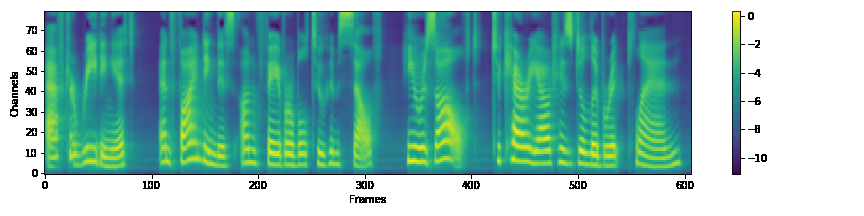

In [63]:
gen.mel

In [64]:
gen.tt

Namespace(audio=0.3679006099700928, durs=0.006528615951538086, mel=0.012000083923339844)

## Latency

In [57]:
def bunch(infer, data, trials=200):
    texts = [e['text'] for e in nemo_asr.parts.manifest.item_iter(data)]
    
    durs, mel, audio, mel_len = [], [], [], []
    for _ in tqdm.notebook.trange(trials):
        gen = infer(np.random.choice(texts))
        tt = gen.tt

        durs.append(tt.durs)
        mel.append(tt.mel)
        audio.append(tt.audio)
        mel_len.append(gen.data.mel.shape[1])
        
    durs, mel, audio, mel_len = (
        np.array(durs), np.array(mel), np.array(audio), np.array(mel_len),
    )

    return argparse.Namespace(durs=durs, mel=mel, audio=audio, mel_len=mel_len)


ltt = bunch(infer, TEST)
ltt.mel.mean(), ltt.mel.std()

(0.012108373641967773, 0.003122976736037152)

0.01734735190502705 0.00036269689833842424


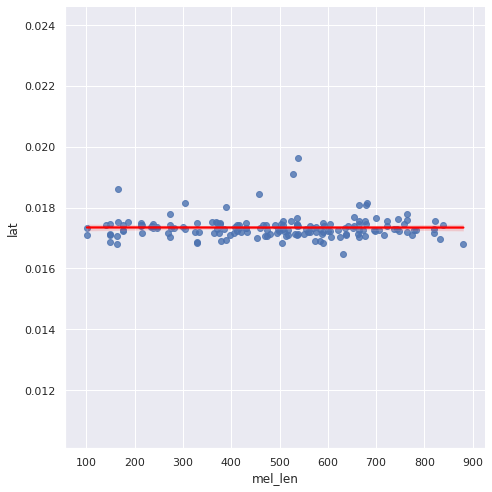

In [70]:
data = np.array([ltt.mel_len, ltt.durs + ltt.mel]).T
data = data[data[:, 1] < 0.02]
data = pd.DataFrame(data=data, columns=['mel_len', 'lat'])
print(data['lat'].mean(), data['lat'].std())
sns.lmplot(x='mel_len', y='lat', data=data, height=7, line_kws={'color': 'red'});

## Robustnes Test

In [13]:
PHRASE = '''\
You can call me directly at four two five seven zero three seven three four four or my cell four 
two five four four four seven four seven four or send me a meeting request with all the appropriate information.\
'''
infer(PHRASE).audio

In [14]:
infer_new(PHRASE).audio

In [15]:
infer_new('To deliver interfaces that are significantly better suited to create and process RFC eight twenty one, RFC eight twenty two, RFC nine seventy seven, and MIME content.').audio

In [16]:
infer('Would you like a cup of tea?', denoiser=0.05).audio

In [19]:
infer_new('Would you like a cup of tea', denoiser=0.05).audio

In [22]:
infer('No, thanks.', denoiser=0.05).audio

In [26]:
infer_new('one 1 I.').audio

In [28]:
infer('I won!').audio

In [35]:
gen = infer('I and my daisy bell.', denoiser=0.02)
gen.audio

In [131]:
gen.durs

~,i,~,,~,a,~,n,~,d,~,,~,m,~,y,~,,~,d,~,a,~,i,~,s,~,y,~,,~,b,~,e,~,l,~,l,~
6,1,31,1,2,1,2,1,0,1,5,1,2,1,2,1,13,1,4,1,2,1,7,1,1,1,12,1,13,1,3,1,2,1,5,1,2,1,1
